In [21]:
import numpy as np
import scipy.sparse as sp
# from time import time
from matplotlib import pyplot as plt
from sklearn.utils.extmath import randomized_svd

Generowanie macierzy

In [22]:
def generate_3d_grid_matrix(k):
    size = 2**(3*k)
    grid_size = 2**k

    # Inicjalizacja rzadkiej macierzy
    matrix = sp.lil_matrix((size, size), dtype=float)

    # Iteracja przez elementy sześcienne siatki
    for i in range(grid_size):
        for j in range(grid_size):
            for l in range(grid_size):
                # Indeks aktualnego wierzchołka
                current_vertex = i * grid_size**2 + j * grid_size + l

                # Iteracja przez sąsiadów
                for di, dj, dl in [(-1, 0, 0), (1, 0, 0), (0, -1, 0), (0, 1, 0), (0, 0, -1), (0, 0, 1)]:
                    ni, nj, nl = i + di, j + dj, l + dl

                    # Sprawdzenie, czy sąsiad mieści się w siatce
                    if 0 <= ni < grid_size and 0 <= nj < grid_size and 0 <= nl < grid_size:
                        neighbor_vertex = ni * grid_size**2 + nj * grid_size + nl

                        # Przypisanie losowej wartości sąsiadowi
                        matrix[current_vertex, neighbor_vertex] = np.random.rand()

    return matrix

# test
for k in range(2, 5):
    matrix = generate_3d_grid_matrix(k)
    print(f"Matrix for k={k}:\n{matrix.toarray()}\n")

Matrix for k=2:
[[0.         0.59253045 0.         ... 0.         0.         0.        ]
 [0.39536883 0.         0.24039055 ... 0.         0.         0.        ]
 [0.         0.63988294 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.86969702 0.        ]
 [0.         0.         0.         ... 0.37762535 0.         0.51074544]
 [0.         0.         0.         ... 0.         0.72591825 0.        ]]

Matrix for k=3:
[[0.         0.90703732 0.         ... 0.         0.         0.        ]
 [0.78634757 0.         0.67214339 ... 0.         0.         0.        ]
 [0.         0.87046995 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.32055358 0.        ]
 [0.         0.         0.         ... 0.39417583 0.         0.53582825]
 [0.         0.         0.         ... 0.         0.63133826 0.        ]]

Matrix for k=4:
[[0.         0.54011269 0.         ... 0.         0.         0

Kompresja macierzy

In [23]:
class Node:
    def __init__(self, t_min, t_max, s_min, s_max):
        self.t_min = t_min
        self.t_max = t_max
        
        self.s_min = s_min
        self.s_max = s_max
        
        self.rank = None
        
        #[A11, A12]
        #[A21, A22]
        
        self.U = None
        self.S = None
        self.VT = None
        
        self.zeros = False
        
        
        self.children = []

In [24]:
def is_admissible(matrix, S, r, eps):
    if min(matrix.shape) <= r:
        return True
    
    if S[-1] < eps:
        return True
    
    return False     

In [25]:
def create_tree(matrix, r, eps):
    n, m = matrix.shape

    
    def create_tree_r(t_min, t_max, s_min, s_max):
        nonlocal matrix, r, eps
        
        if not np.any(matrix[t_min:t_max, s_min:s_max]):
            v = Node(t_min, t_max, s_min, s_max)
            v.rank = 0
            v.zeros = True
            return v
    
        U,S,V = randomized_svd(matrix[t_min:t_max, s_min:s_max], r)
        
        S = S[S >= eps]  
        rank = len(S)
        
        U = U[:, :rank]
        V = V[:rank, :]
        if rank == 0:
            v = Node(t_min, t_max, s_min, s_max)
            v.rank = 0
            v.zeros = True
            return v
        
        
        if is_admissible(matrix[t_min:t_max, s_min:s_max], S, r, eps):
            v = Node(t_min, t_max, s_min, s_max) #compress matrix
            v.rank = rank
            v.U = U
            v.S = S
            v.V = V
            return v
            
        else:
            v = Node(t_min, t_max, s_min, s_max)
            
            t_newmax = (t_min + t_max)//2
            s_newmax = (s_min + s_max)//2
            
            v1 = create_tree_r(t_min, t_newmax, s_min, s_newmax)
            v2 = create_tree_r(t_min, t_newmax, s_newmax, s_max)
            v3 = create_tree_r(t_newmax, t_max, s_min, s_newmax)
            v4 = create_tree_r(t_newmax, t_max, s_newmax, s_max)
            
            v.children = [v1, v2, v3, v4]
        return v
    return create_tree_r(0, n, 0, m)

In [26]:
def decompress(node):
    if node.rank is not None:
        if node.rank > 0:
            return node.U@np.diag(node.S)@node.V
        else:
            return np.zeros((node.t_max - node.t_min, node.s_max - node.s_min))
    else:
        return np.vstack(
            (
                np.hstack((decompress(node.children[0]), decompress(node.children[1]))),
                np.hstack((decompress(node.children[2]), decompress(node.children[3]))),
            )
        )   

Rysowacz:)

In [96]:
def plot_matrix(root, matrix, title = None):
    size = matrix.shape
    tmap = np.zeros(size)
    
    def fill_map(node):
        nonlocal tmap
        if node.rank is not None:
            if node.rank != 0:
                tmap[node.t_min:node.t_max, node.s_min:node.s_min + node.rank] = 1
                tmap[node.t_min:node.t_min + node.rank, node.s_min:node.s_max] = 1
        else:
            for submatrix in node.children:
                fill_map(submatrix)
    fill_map(root)
    _, ax = plt.subplots(1,1)
    ax.spy(tmap)
    if title is not None:
        ax.set_title(title)
        
def plot_sparisity(matrix, title=None):
    _, ax = plt.subplots(1,1)
    ax.spy(matrix)
    if title is not None:
        ax.set_title(title)

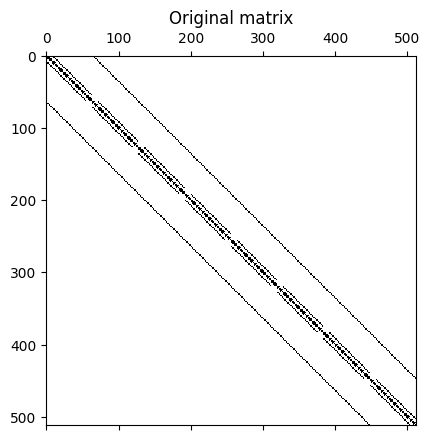

In [52]:
matrix = generate_3d_grid_matrix(3).toarray()
root = create_tree(matrix, 3, 10**(-8))
plot_matrix(root, matrix, "Original matrix")

Permutacje macierzy

In [50]:
from queue import PriorityQueue

In [199]:
def permutate_matrix(matrix, permutation):
    size = len(matrix)
    new_matrix = np.zeros((size, size))
    for i in range(size):
        new_matrix[i] = matrix[permutation[i]]
    
    new_matrix_cols = np.zeros((size, size))
    for i in range(size):
        new_matrix_cols[:, i] = new_matrix[:, permutation[i]]
            
    return new_matrix_cols

In [270]:
def minimum_degree_ordering(matrix):
    n = len(matrix)
    permutation = [None for _ in range(n)]
    adjacent = {i:set() for i in range(n)}
    
    for i in range(n):
        for j in range(n):
            if matrix[i][j] != 0:
                adjacent[i].add(j)
                
    for i in range(n):
        min_deg = n + 1
        min_idx = None
        for idx, deg in adjacent.items():
            if len(deg) < min_deg:
                min_idx = idx
                min_deg = len(deg)
                
        permutation[i] = min_idx
        
        
        for j in adjacent:
            adjacent[j].discard(min_idx)
        for v in adjacent[min_idx]:
            adjacent[v].update(adjacent[min_idx] - {v})
        adjacent.pop(min_idx)

    return permutation

In [244]:
matrix = generate_3d_grid_matrix(3).toarray()
_, S, _ = np.linalg.svd(matrix)

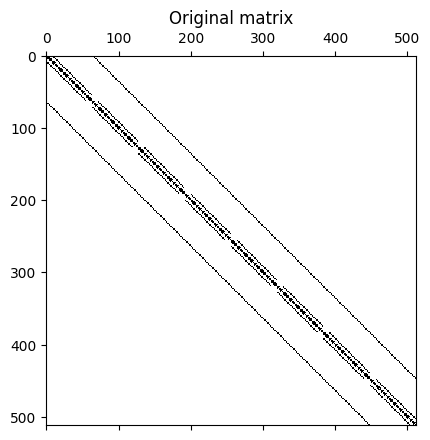

In [245]:
root = create_tree(matrix, 2, S[-1])
plot_matrix(root, matrix, "Original matrix")

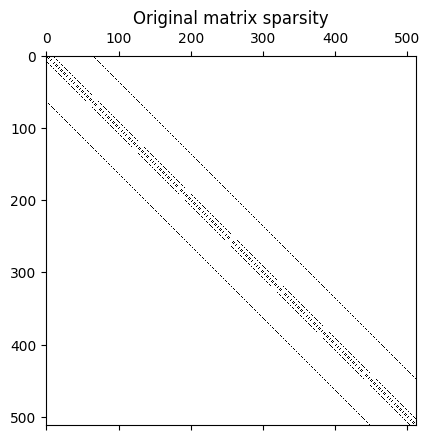

In [246]:
plot_sparisity(matrix, "Original matrix sparsity")

[0, 7, 56, 63, 448, 455, 504, 511, 2, 4, 16, 23, 32, 39, 58, 60, 128, 135, 184, 191, 256, 263, 312, 319, 450, 452, 464, 471, 480, 487, 506, 508, 6, 9, 11, 13, 18, 20, 25, 27, 29, 34, 36, 41, 43, 45, 48, 54, 65, 67, 69, 72, 79, 88, 95, 104, 111, 121, 123, 125, 130, 132, 144, 151, 160, 167, 186, 188, 193, 195, 197, 200, 207, 216, 223, 232, 239, 249, 251, 253, 258, 260, 272, 279, 288, 295, 314, 316, 321, 323, 325, 328, 335, 344, 351, 360, 367, 377, 379, 381, 384, 390, 432, 439, 446, 457, 459, 461, 466, 468, 473, 475, 477, 482, 484, 489, 491, 493, 502, 74, 76, 81, 83, 85, 90, 92, 97, 99, 101, 106, 108, 137, 139, 141, 146, 148, 153, 155, 157, 162, 164, 169, 171, 173, 182, 202, 204, 209, 211, 213, 218, 220, 225, 227, 229, 234, 236, 265, 267, 269, 274, 276, 281, 283, 285, 290, 292, 297, 299, 301, 310, 330, 332, 337, 339, 341, 346, 348, 353, 355, 357, 362, 364, 383, 406, 422, 434, 436, 495, 509, 22, 38, 50, 52, 55, 134, 176, 262, 304, 386, 388, 391, 400, 416, 440, 1, 62, 247, 254, 415, 443, 45

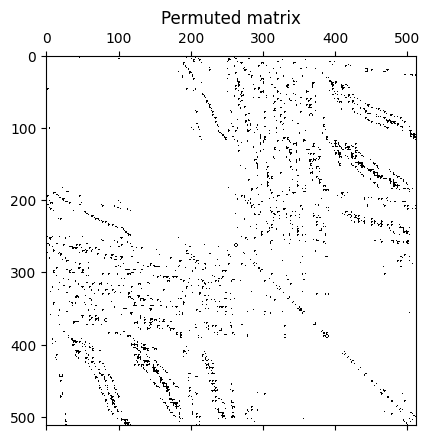

In [269]:
permutation = minimum_degree_ordering(matrix)
print(permutation)
perm_matrix = permutate_matrix(matrix, permutation)
root = create_tree(perm_matrix, 2, S[-1])
plot_matrix(root, perm_matrix, "Permuted matrix")

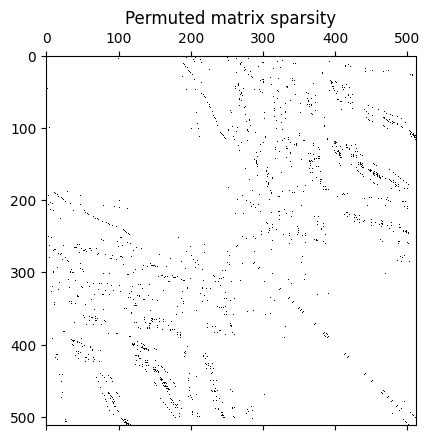

In [271]:
plot_sparisity(perm_matrix, "Permuted matrix sparsity")